In [3]:
import numpy as np
import pandas as pd
import os
import rasterio
from rasterio.windows import Window
import cv2
import tqdm
import random
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     print(dirname)
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
config = {
    'resize': (512,512), #(1024,1024)
    'DATA': '/kaggle/input/hubmap-organ-segmentation/train_images',
    'MASKS' : '/kaggle/input/hubmap-organ-segmentation/train.csv',
    'Window' : (0,3000), #(250,2670)
}

In [5]:
#Helper functions
#convert encoding rle to mask
def enc2mask(encs, shape):
    '''
    Args:
    encs: list of rle masks
    shape: mask shape
    return numpy array, 1 -> mask, 0 -> background
    '''
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for m,enc in enumerate(encs):
        if isinstance(enc,np.float32) and np.isnan(enc): continue
        s = enc.split()
        for i in range(len(s)//2):
            start = int(s[2*i]) - 1
            length = int(s[2*i+1])
            img[start:start+length] = 1 + m
    return img.reshape(shape).T

#convert mask back to encoding rle
def mask2enc(mask, shape):
    '''
    Args:
    img: numpy array, 1 -> mask, 0 -> background
    return run length encoding in string format
    '''
    mask = cv2.resize(mask, (shape[0], shape[1]), interpolation=cv2.INTER_CUBIC)
    #this scale up is inaccurate, please check out predictions_mask_ensemble 
    #for actually matching the prediction & ground truth in 
    #https://www.kaggle.com/code/gunesevitan/hubmap-hpa-hacking-the-human-body-inference
    #resize outside of this func during test evaluations?
    pixels= mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [28]:
#test above 2 functions

#3000 x 3000
tempdata = rasterio.open(os.path.join(config['DATA'],'10044.tiff'))
tempmask = enc2mask(df_masks.loc[10044],(tempdata.shape[1],tempdata.shape[0]))
print(sum(sum(tempmask)))
temprle = mask2enc(tempmask, tempmask.shape)
# print(temprle) 
#print(df_masks.loc[10044][0])
print(temprle == df_masks.loc[10044][0])
print(tempmask.shape)

#512 x 512
slide=config['Window']
resize=config['resize']
tempdata = tempdata.read([1,2,3],window=Window.from_slices(slide,slide)) 
tempmask = tempmask[slide[0]:slide[1], slide[0]:slide[1]] 
tempdata = cv2.resize(np.transpose(tempdata,(1,2,0)),(resize[0],resize[1]),
                         interpolation = cv2.INTER_AREA)
tempmask = cv2.resize(tempmask,(resize[0], resize[1]),
                          interpolation = cv2.INTER_NEAREST)
print(sum(sum(tempmask)))
temprle = mask2enc(tempmask, (3000, 3000))
print(tempmask.shape)

#impossible to be the same after image interpolation
print(temprle == df_masks.loc[10044][0])
print(len(temprle))
print(len(df_masks.loc[10044][0]))
#even the length of rle is different
print(len(temprle) == len(df_masks.loc[10044][0]))

# binary_intersection_over_union(ground_truth, predictions) 
# ground_truth & predictions are numpy arrays
# visualize_predictions also seems helpful
# link in next section

220068
True
(3000, 3000)
39046
(512, 512)
False
53319
53275
False


In [23]:
# https://www.kaggle.com/code/gunesevitan/hubmap-hpa-hacking-the-human-body-inference
def binary_intersection_over_union(ground_truth, predictions, threshold=0.5, eps=0.00001):

    """
    Calculate intersection over union on given ground truth and predictions arrays

    Parameters
    ----------
    ground_truth (array-like of shape (batch_size, height, width) or (height, width)): Ground truth array
    predictions (array-like of shape (batch_size, height, width) or (height, width)): Predictions array
    threshold (float): Threshold for converting soft predictions into hard labels (0 <= threshold <= 1)
    eps (float): A small number for avoiding division by zero

    Returns
    -------
    intersection_over_union (float): Calculated intersection over union
    """

    if isinstance(ground_truth, torch.Tensor):
        ground_truth = ground_truth.numpy().astype(np.float32)
    else:
        ground_truth = np.array(ground_truth).astype(np.float32)

    if isinstance(predictions, torch.Tensor):
        predictions = predictions.numpy().astype(np.float32)
    else:
        predictions = np.array(predictions).astype(np.float32)

    if len(ground_truth.shape) != len(predictions.shape):
        raise ValueError('Shape mismatch')

    predictions = soft_predictions_to_labels(x=predictions, threshold=threshold).astype(np.float32)

    if len(ground_truth.shape) == 2:
        # Calculate intersection over union for single data point
        intersection = np.sum(ground_truth * predictions)
        union = np.sum(ground_truth + predictions - ground_truth * predictions)
        intersection_over_union = (intersection + eps) / (union + eps)
    elif len(ground_truth.shape) == 3:
        # Calculate intersection over union for batch of data points (assuming first dimension is batch)
        intersection = np.sum(ground_truth * predictions, axis=(1, 2))
        union = np.sum(ground_truth + predictions - ground_truth * predictions, axis=(1, 2))
        intersection_over_union = np.mean((intersection + eps) / (union + eps))
    else:
        raise ValueError('Invalid shape')

    return float(intersection_over_union)

In [7]:
df_masks = pd.read_csv(config['MASKS'])[['id', 'rle','organ']].set_index('id')
# df_masks.head()
# df_masks.loc[df_masks["organ"] == "kidney"].head(80)
# df_masks.loc[df_masks["organ"] == "kidney"].tail(19)

# kidney 99=80:19
# prostate 93=75:18
# large intestine 58=47:11
# spleen 53=43:10
# lung 48=39:9
# total 351=284:67=4:1
kidney = df_masks.loc[df_masks["organ"] == "kidney"].index.values.tolist()
prostate = df_masks.loc[df_masks["organ"] == "prostate"].index.values.tolist()
largeintestine = df_masks.loc[df_masks["organ"] == "largeintestine"].index.values.tolist()
spleen = df_masks.loc[df_masks["organ"] == "spleen"].index.values.tolist()
lung = df_masks.loc[df_masks["organ"] == "lung"].index.values.tolist()

# len(kidney) #99
# kidney[:80]
# kidney[-19:]
# len(kidney[:80] + kidney[-19:]) #99

train = kidney[:80] + prostate[:75] + largeintestine[:47] + spleen[:43] + lung[:39]
valid = kidney[-19:] + prostate[-18:] + largeintestine[-11:] + spleen[-10:] + lung[-9:]
len(train+valid)

351

In [18]:
#resize & cutoff each image mask pair with consistent dim
class HPAData():
    def __init__(self, idx, resize=config['resize'], slide=config['Window'], encs=None):
        self.data = rasterio.open(os.path.join(config['DATA'],str(idx)+'.tiff'), num_threads='all_cpus')
#         print(self.data)
        
        # some images have issues with their format 
        # and must be saved correctly before reading with rasterio
        if self.data.count != 3:
            subdatasets = self.data.subdatasets
            self.layers = []
            if len(subdatasets) > 0:
                for i, subdataset in enumerate(subdatasets, 0):
                    self.layers.append(rasterio.open(subdataset))
                    
        self.shape = self.data.shape
        self.slide = slide
        self.resize = resize
        self.idx = idx
        
        self.mask = enc2mask(encs,(self.shape[1],self.shape[0])) if encs is not None else None
        
    def __len__(self):
        return 1
    
    def __getitem__(self, idx):
        # read img (RGB), mask (grayscale) from window slide
        # img, mask: uint8
        img = self.data.read([1,2,3],window=Window.from_slices(self.slide,self.slide)) 
        mask = self.mask[self.slide[0]:self.slide[1], self.slide[0]:self.slide[1]] 
        
        # resize
        img = cv2.resize(np.transpose(img,(1,2,0)),(self.resize[0],self.resize[1]),
                         interpolation = cv2.INTER_AREA)
        mask = cv2.resize(mask,(self.resize[0], self.resize[1]),
                          interpolation = cv2.INTER_NEAREST)
        
        return img, mask, self.idx

In [19]:
#process train & validation sets
class HPADataset(Dataset):
    def __init__(self, category): #transform=None, target_transform=None
        self.total = 0
        self.img = []
        self.mask = []
        
        if category == "train":
            tempid = train
        elif category == "validation":
            tempid = valid
        else:
            print("Not matching either train/validation")
        
#         for index, row in df_masks.iterrows():
        for index in tempid:
            row = df_masks.loc[index]
            #rle: df_masks.loc[index][0], organ: df_masks.loc[index][1]
            print("{}: categorize image & mask {} with organ type {}".format(self.total, index, df_masks.loc[index][1])) 
            dp = HPAData(index,encs=row)
            img, m, idx = dp[0]

            #write data   
            # Convert BGR image to RGB image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#             print(img)

            # Define a transform to convert the image to torch tensor
            transform = transforms.Compose([
                transforms.ToTensor()
            ])

            # Convert the image to Torch tensor
            tensorImg = transform(img) #F.pil_to_tensor(img)
#             print(tensorImg.shape)
#             print(tensorImg)

#https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html
#ToTensor() should not be used when transforming target image masks...
            tensorMask = torch.as_tensor(np.array(m), dtype=torch.int64) #transform(m)
#             print(tensorMask.shape)
#             print(sum(tensorMask))

#             plt.imshow(Image.fromarray(img))
#             plt.imshow(Image.fromarray(m), alpha=0.2)
            self.img.append(tensorImg)
            self.mask.append(tensorMask)
            self.total+=1
            
    def __len__(self):
        return self.total
    
    def __getitem__(self, idx):
        image = self.img[idx]
        mask = self.mask[idx]
        
        return image, mask
        

0: categorize image & mask 10611 with organ type kidney
1: categorize image & mask 11497 with organ type kidney
2: categorize image & mask 1157 with organ type kidney
3: categorize image & mask 12784 with organ type kidney
4: categorize image & mask 13034 with organ type kidney
5: categorize image & mask 13260 with organ type kidney
6: categorize image & mask 14756 with organ type kidney
7: categorize image & mask 15005 with organ type kidney
8: categorize image & mask 15192 with organ type kidney
9: categorize image & mask 15787 with organ type kidney
10: categorize image & mask 15860 with organ type kidney
11: categorize image & mask 16163 with organ type kidney
12: categorize image & mask 16214 with organ type kidney
13: categorize image & mask 16216 with organ type kidney
14: categorize image & mask 16362 with organ type kidney
15: categorize image & mask 164 with organ type kidney
16: categorize image & mask 16711 with organ type kidney
17: categorize image & mask 17422 with organ

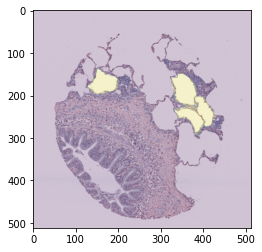

In [20]:
trainset = HPADataset("train")
validset = HPADataset("validation")
#0-283 + 0-66 = 284+67=351

In [21]:
# load data using DataLoader
train_loader = DataLoader(trainset, batch_size=4, shuffle=True) #batch_size=3
valid_loader = DataLoader(validset, batch_size=4, shuffle=True)

for i, (images, masks) in enumerate(train_loader):
    print(images.shape)

torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4, 3, 512, 512])
torch.Size([4,